**MSc in Big Data & Analytics Kosmas Katsioulas | ME2109 | Part D - Action Recognition Models**

# **Libraries & Packages**

In [1]:
!pip -q install pandas==2.2.2 numpy==2.0.0 scikit-learn==1.6 seaborn==0.13.2 matplotlib==3.8.4 tqdm==4.67

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.3 MB/s eta 0:00:00


In [2]:
import os, glob, re, json, math, random, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from zipfile import ZipFile
from collections import Counter
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [3]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)

In [4]:
sns.set(style="whitegrid", font_scale=1.0)
plt.rcParams["figure.figsize"] = (7,4)
plt.rcParams["savefig.dpi"] = 150
warnings.filterwarnings("ignore")

In [5]:
results_Dir = "/content/Results_Action_Recognition"
os.makedirs(results_Dir, exist_ok=True)

# **Mount Google Drive**

In [6]:
IN_COLAB = False
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except Exception:
    pass

Mounted at /content/drive


# **Useful Paths**

In [7]:
zip_path   = '/content/drive/MyDrive/Diploma/UNIRI_HBD_Dataset/uniri-hbd.zip'
extract_to = '/content/uniri-hbd'

In [8]:
if os.path.exists(zip_path) and not os.path.exists(extract_to):

    with ZipFile(zip_path, 'r') as zf:

        zf.extractall(extract_to)

    print("Dataset extracted ->", extract_to)

else:

    print("Zip not used or dataset already extracted / not found.")

Dataset extracted -> /content/uniri-hbd


In [9]:
base_dir = os.path.join(extract_to, "handball_s")
dets_dir = os.path.join(base_dir, "player_detections")
scenes_dir = os.path.join(base_dir, "scenes")

# **Useful Functions**

**Parse CSV**

In [10]:
def parse_uniri_csv(csv_path: str) -> pd.DataFrame:

    rows, current_frame = [], None

    with open(csv_path, "r") as f:

        for raw in f:

            line = raw.strip()

            if not line:

                continue

            if line.lower().startswith("frame"):

                nums = re.findall(r"\d+", line)
                current_frame = int(nums[0]) if nums else None
                continue

            parts = re.split(r"[,\s]+", line.strip(", "))

            if current_frame is None or len(parts) < 5:
                continue

            try:
                x1, y1, x2, y2, conf = map(float, parts[:5])
                rows.append([current_frame, x1, y1, x2, y2, conf])

            except Exception:
                pass

    df = pd.DataFrame(rows, columns=["frame","x1","y1","x2","y2","conf"])

    if not df.empty:

        df = df.sort_values("frame").reset_index(drop=True)

    return df

**Build Dataset**

In [11]:
actions = sorted([d for d in os.listdir(dets_dir) if os.path.isdir(os.path.join(dets_dir, d))])

In [12]:
print("Actions discovered:", actions)

Actions discovered: ['crossing', 'defence', 'dribbling', 'jump-shot', 'passing', 'running', 'shot']


In [13]:
def clip_features_from_csv(csv_path: str) -> dict:

    action = Path(csv_path).parent.name
    clip_id = Path(csv_path).stem

    df = parse_uniri_csv(csv_path)
    if df.empty:
        return {
            "action": action, "clip": clip_id,
            "frames_covered_ratio": 0.0,
            "count_mean": 0.0, "count_std": 0.0,
            "bbox_w_mean": 0.0, "bbox_h_mean": 0.0, "bbox_area_mean": 0.0, "bbox_ar_mean": 0.0,
            "bbox_w_std": 0.0, "bbox_h_std": 0.0, "bbox_area_std": 0.0, "bbox_ar_std": 0.0,
            "conf_p10": 0.0, "conf_med": 0.0, "conf_p90": 0.0,
            "tiny_ratio": 0.0, "empty_ratio": 1.0,
        }

    # valid widths / heights
    df["w"] = (df.x2 - df.x1).clip(lower=0)
    df["h"] = (df.y2 - df.y1).clip(lower=0)
    df = df[(df.w > 1) & (df.h > 1)].copy()
    if df.empty:
        return {
            "action": action, "clip": clip_id,
            "frames_covered_ratio": 0.0,
            "count_mean": 0.0, "count_std": 0.0,
            "bbox_w_mean": 0.0, "bbox_h_mean": 0.0, "bbox_area_mean": 0.0, "bbox_ar_mean": 0.0,
            "bbox_w_std": 0.0, "bbox_h_std": 0.0, "bbox_area_std": 0.0, "bbox_ar_std": 0.0,
            "conf_p10": 0.0, "conf_med": 0.0, "conf_p90": 0.0,
            "tiny_ratio": 0.0, "empty_ratio": 1.0,
        }

    # geometric stats
    df["area"] = df.w * df.h
    df["ar"]   = (df.w / df.h).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    # per-frame detection counts
    counts = df.groupby("frame").size()
    count_mean, count_std = float(counts.mean()), float(counts.std() if len(counts)>1 else 0.0)

    # frame coverage ratio over contiguous range
    frames = sorted(df.frame.unique())
    fmin, fmax = int(min(frames)), int(max(frames))
    expected = (fmax - fmin + 1)
    covered  = len(frames)
    frames_covered_ratio = float(covered / expected) if expected > 0 else 0.0

    # confidence distribution
    conf_p10 = float(df.conf.quantile(0.10))
    conf_med = float(df.conf.median())
    conf_p90 = float(df.conf.quantile(0.90))

    # bbox stats
    w_mean, h_mean = float(df.w.mean()), float(df.h.mean())
    a_mean, ar_mean = float(df.area.mean()), float(df.ar.mean())
    w_std,  h_std   = float(df.w.std() if len(df)>1 else 0.0), float(df.h.std() if len(df)>1 else 0.0)
    a_std,  ar_std  = float(df.area.std() if len(df)>1 else 0.0), float(df.ar.std() if len(df)>1 else 0.0)

    # tiny / empty ratios
    tiny_ratio  = float(((df.w < 8) | (df.h < 8)).mean())
    empty_ratio = float(1.0 - (covered / expected)) if expected>0 else 1.0

    return {
        "action": action, "clip": clip_id,
        "frames_covered_ratio": frames_covered_ratio,
        "count_mean": count_mean, "count_std": count_std,
        "bbox_w_mean": w_mean, "bbox_h_mean": h_mean,
        "bbox_area_mean": a_mean, "bbox_ar_mean": ar_mean,
        "bbox_w_std": w_std, "bbox_h_std": h_std,
        "bbox_area_std": a_std, "bbox_ar_std": ar_std,
        "conf_p10": conf_p10, "conf_med": conf_med, "conf_p90": conf_p90,
        "tiny_ratio": tiny_ratio, "empty_ratio": empty_ratio,
    }

In [14]:
# Collect features for all CSVs
rows = []
max_csv_per_action = None

In [15]:
for act in actions:

    csvs = sorted(glob.glob(os.path.join(dets_dir, act, "*.csv")))

    if max_csv_per_action is not None:

        csvs = csvs[:max_csv_per_action]

    for cp in tqdm(csvs, desc=f"Build features — {act}"):

        rows.append(clip_features_from_csv(cp))

Build features — shot: 100%|██████████| 102/102 [00:02<00:00, 46.38it/s]


In [16]:
df_data = pd.DataFrame(rows).sort_values(["action","clip"]).reset_index(drop=True)
print("Dataset shape:", df_data.shape)

Dataset shape: (751, 18)


In [17]:
display(df_data.head())
df_data.to_csv(os.path.join(results_Dir, "Clips_Features_Table_Kosmas_Katsioulas_ME2109.csv"), index=False)

,action,clip,frames_covered_ratio,count_mean,count_std,bbox_w_mean,bbox_h_mean,bbox_area_mean,bbox_ar_mean,bbox_w_std,bbox_h_std,bbox_area_std,bbox_ar_std,conf_p10,conf_med,conf_p90,tiny_ratio,empty_ratio
0,crossing,crossing_KS_1,1.0,21.304878,1.960656,311.265400,164.369051,127610.790630,1.098358,521.975183,159.954694,280635.764448,1.394429,0.073535,0.710556,0.993532,0.000000,0.0
1,crossing,crossing_KS_10,1.0,18.271605,2.449553,315.265038,167.509717,131596.595864,1.097841,523.044526,165.157321,288217.304631,1.349153,0.076476,0.841927,0.994370,0.003378,0.0
2,crossing,crossing_KS_100,1.0,13.716418,1.873305,219.620627,122.669896,75058.913740,0.868544,481.701366,109.751358,191853.232941,1.248578,0.063750,0.398354,0.995823,0.003264,0.0
3,crossing,crossing_KS_101,1.0,12.888889,2.269361,229.877477,161.254448,119202.289894,0.738226,497.689024,172.507922,321897.392359,0.786600,0.065702,0.713896,0.997416,0.000958,0.0
4,crossing,crossing_KS_102,1.0,12.109756,2.424189,329.758004,174.651949,158942.006073,1.018533,593.405988,180.416873,355828.613926,1.127769,0.065138,0.252524,0.996796,0.012085,0.0


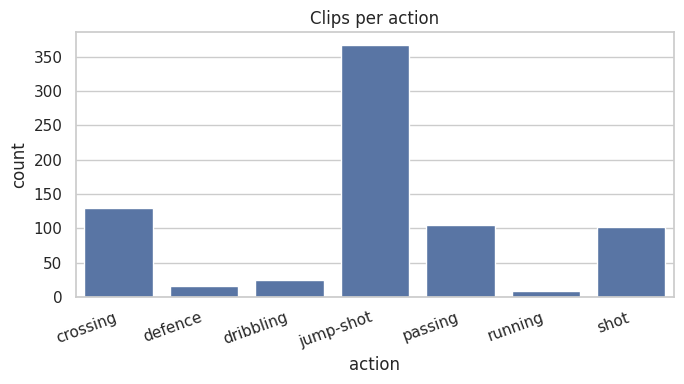

In [18]:
plt.figure(figsize=(7,4))
sns.countplot(data=df_data, x="action")
plt.title("Clips per action")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.savefig(os.path.join(results_Dir, "Class_Distribution_Kosmas_Katsioulas_ME2109.png"))
plt.show()

# **Features / Labels**

**Train / Val / Test**

In [19]:
# Features/labels
feature_cols = [c for c in df_data.columns if c not in ["action","clip"]]
X = df_data[feature_cols].values
y = df_data["action"].values

In [20]:
X_tr, X_temp, y_tr, y_temp = train_test_split(X, y, test_size=0.30, random_state=SEED, stratify=y)
X_val, X_te, y_val, y_te = train_test_split(X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp)

In [21]:
print("Split sizes:", len(y_tr), len(y_val), len(y_te))

Split sizes: 525 113 113


# **Random Forest Classifier**

In [22]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=SEED,
    n_jobs=-1
)

In [23]:
param_grid_rf = {
    "n_estimators": [300, 500],
    "min_samples_leaf": [1, 2, 3],
    "max_features": ["sqrt", 0.5],
}

In [24]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [25]:
gs_rf = GridSearchCV(rf, param_grid_rf, scoring="f1_macro", cv=cv, n_jobs=-1, verbose=0)

In [26]:
gs_rf.fit(X_tr, y_tr)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              min_samples_leaf=2,
                                              n_estimators=400, n_jobs=-1,
                                              random_state=0),
             n_jobs=-1,
             param_grid={'max_features': ['sqrt', 0.5],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [300, 500]},
             scoring='f1_macro')

In [27]:
best_rf = gs_rf.best_estimator_
print("RF best params:", gs_rf.best_params_)

RF best params: {'max_features': 0.5, 'min_samples_leaf': 2, 'n_estimators': 500}


In [28]:
y_val_rf = best_rf.predict(X_val)
print("\nRandomForest")
print("Accuracy:", round(accuracy_score(y_val, y_val_rf), 3))
print("Macro-F1:", round(f1_score(y_val, y_val_rf, average="macro"), 3))


RandomForest
Accuracy: 0.796
Macro-F1: 0.621


In [29]:
X_trval = np.vstack([X_tr, X_val])
y_trval = np.hstack([y_tr, y_val])

In [30]:
best_rf.fit(X_trval, y_trval)
y_te_rf = best_rf.predict(X_te)

In [31]:
print("\nRandomForest")
print("Accuracy:", round(accuracy_score(y_te, y_te_rf), 3))
print("Macro-F1:", round(f1_score(y_te, y_te_rf, average="macro"), 3))
print(classification_report(y_te, y_te_rf, digits=3))


RandomForest
Accuracy: 0.805
Macro-F1: 0.745
              precision    recall  f1-score   support

    crossing      0.750     0.900     0.818        20
     defence      1.000     0.500     0.667         2
   dribbling      0.500     0.333     0.400         3
   jump-shot      0.828     0.873     0.850        55
     passing      0.867     0.812     0.839        16
     running      1.000     1.000     1.000         1
        shot      0.750     0.562     0.643        16

    accuracy                          0.805       113
   macro avg      0.813     0.712     0.745       113
weighted avg      0.804     0.805     0.799       113



# **ExtraTrees**

In [32]:
et = ExtraTreesClassifier(
    n_estimators=600,
    max_depth=None,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=SEED,
    n_jobs=-1
)

In [33]:
param_grid_et = {
    "n_estimators": [400, 800],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", 0.6],
}

In [34]:
gs_et = GridSearchCV(et, param_grid_et, scoring="f1_macro", cv=cv, n_jobs=-1, verbose=0)

In [35]:
gs_et.fit(X_tr, y_tr)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=ExtraTreesClassifier(class_weight='balanced',
                                            n_estimators=600, n_jobs=-1,
                                            random_state=0),
             n_jobs=-1,
             param_grid={'max_features': ['sqrt', 0.6],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [400, 800]},
             scoring='f1_macro')

In [36]:
best_et = gs_et.best_estimator_
print("ExtraTrees best params:", gs_et.best_params_)

ExtraTrees best params: {'max_features': 0.6, 'min_samples_leaf': 2, 'n_estimators': 400}


In [37]:
y_val_et = best_et.predict(X_val)
print("\nExtraTrees")
print("Accuracy:", round(accuracy_score(y_val, y_val_et), 3))
print("Macro-F1:", round(f1_score(y_val, y_val_et, average="macro"), 3))


ExtraTrees
Accuracy: 0.805
Macro-F1: 0.663


In [38]:
best_et.fit(X_trval, y_trval)
y_te_et = best_et.predict(X_te)

In [39]:
print("\nExtraTrees")
print("Accuracy:", round(accuracy_score(y_te, y_te_et), 3))
print("Macro-F1:", round(f1_score(y_te, y_te_et, average="macro"), 3))
print(classification_report(y_te, y_te_et, digits=3))


ExtraTrees
Accuracy: 0.796
Macro-F1: 0.719
              precision    recall  f1-score   support

    crossing      0.783     0.900     0.837        20
     defence      0.500     0.500     0.500         2
   dribbling      0.500     0.333     0.400         3
   jump-shot      0.852     0.836     0.844        55
     passing      0.765     0.812     0.788        16
     running      1.000     1.000     1.000         1
        shot      0.714     0.625     0.667        16

    accuracy                          0.796       113
   macro avg      0.730     0.715     0.719       113
weighted avg      0.794     0.796     0.793       113



# **Confusion Matrix**

In [40]:
def plot_cm(y_true, y_pred, classes, title, save_path):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

In [41]:
class_order = sorted(np.unique(y))

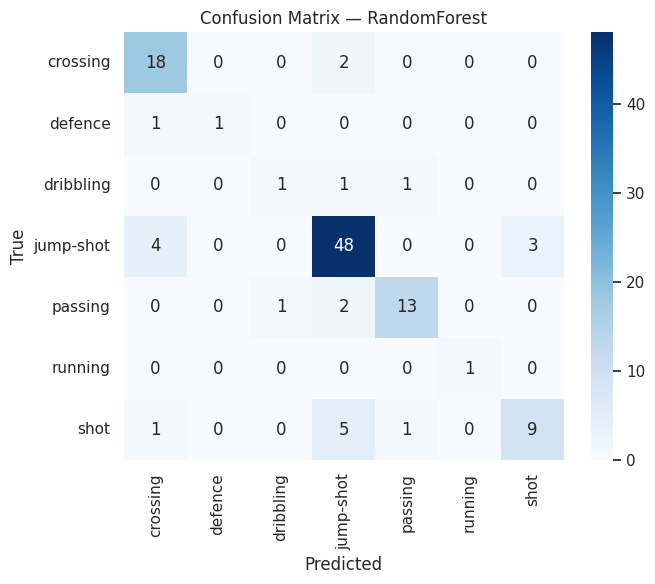

In [42]:
plot_cm(y_te, y_te_rf, class_order,"Confusion Matrix — RandomForest", os.path.join(results_Dir, "cm_rf_Kosmas_Katsioulas_ME2109.png"))

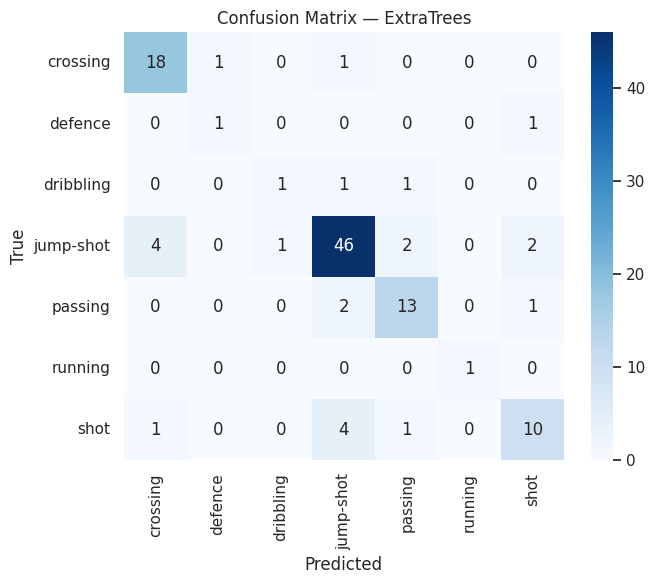

In [43]:
plot_cm(y_te, y_te_et, class_order,"Confusion Matrix — ExtraTrees", os.path.join(results_Dir, "cm_extraTrees_Kosmas_Katsioulas_ME2109.png"))

# **Feature Importance**

In [44]:
def plot_feature_importances(model, feat_names, title, save_path, topk=15):
    imp = np.asarray(model.feature_importances_)
    order = np.argsort(-imp)[:topk]
    plt.figure(figsize=(8,5))
    sns.barplot(x=imp[order], y=np.array(feat_names)[order])
    plt.title(title)
    plt.xlabel("Importance"); plt.ylabel("Feature")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

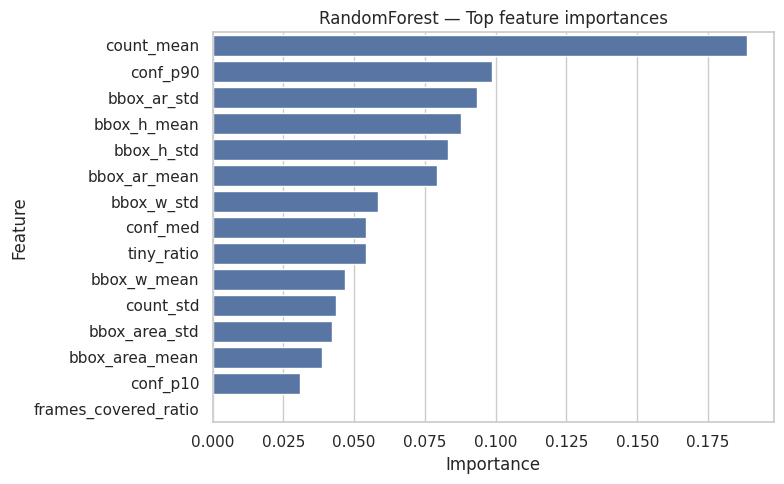

In [45]:
plot_feature_importances(best_rf, feature_cols,"RandomForest — Top feature importances", os.path.join(results_Dir, "rf_feature_importance_Kosmas_Katsioulas_ME2109.png"))

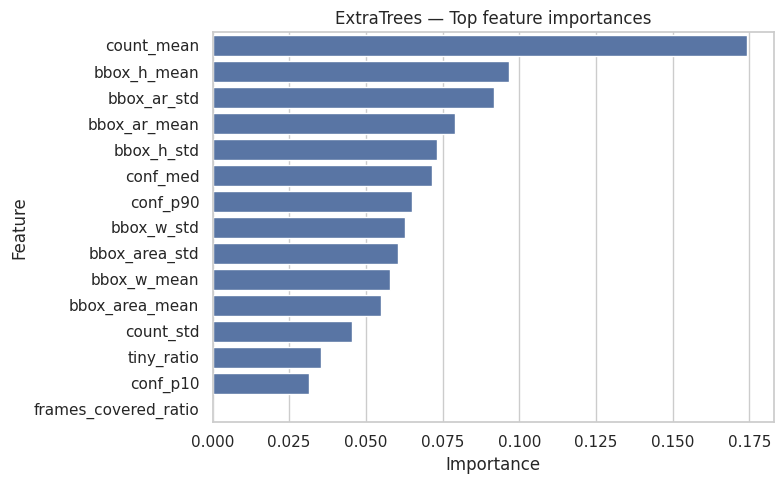

In [46]:
plot_feature_importances(best_et, feature_cols,"ExtraTrees — Top feature importances", os.path.join(results_Dir, "et_feature_importance_Kosmas_Katsioulas_ME2109.png"))

# **Comparison Models (Random Forest vs ExtraTrees)**

In [47]:
def metrics_row(name, y_true, y_pred):
    return {
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "macro_f1": f1_score(y_true, y_pred, average="macro"),
    }

In [48]:
rows = []
rows.append(metrics_row("RandomForest", y_te, y_te_rf))
rows.append(metrics_row("ExtraTrees",   y_te, y_te_et))

In [49]:
df_cmp = pd.DataFrame(rows).sort_values("macro_f1", ascending=False)
display(df_cmp.style.format({"accuracy":"{:.3f}","macro_f1":"{:.3f}"}))

,model,accuracy,macro_f1
0,RandomForest,0.805,0.745
1,ExtraTrees,0.796,0.719
